In [2]:
import os
import pandas as pd
import pickle
from importlib import reload
import lime.lime_rdf
from rdflimeConfig import movieLocation

movieFull = pd.read_csv(os.path.join(movieLocation, "movies_fixed.tsv"), sep="\t")
movies = [movie.DBpedia_URI for _, movie in movieFull.iterrows()]

In [3]:
pcopy = lambda o: pickle.loads(pickle.dumps(o))

In [4]:
reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

with open(os.path.join(movieLocation, "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

with open(os.path.join(movieLocation, "embedding_classifier_cbow_200"), "rb") as file:
    clf = pickle.load(file)

explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=movies,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)

explained_entity_id = 1876  # 1600-1999 -> test data
explained_entity_uri = movies[explained_entity_id]
prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])
print("Explaining", explained_entity_uri)
print("Original prediction:", prediction)
print("True class:", movieFull.iloc[explained_entity_id].label)

data, labels, distances, explanation = explainer.explain_instance(
    entity=explained_entity_uri, 
    classifier_fn=clf.predict_proba,
    num_features=10,
    num_samples=10,
    max_removed_triples=1,
    removal_count_fixed=True,
    use_w2v_freeze=True,
    center_correction=False,
    single_run=True,
    train_with_all=False,
    distance_metric="cosine",
    model_regressor=None,
    short_uris=True
)

Explaining http://dbpedia.org/resource/Cabin_Boy
Original prediction: [[0.86225396 0.13774604]]
True class: bad


100%|██████████| 1/1 [00:00<00:00, 591.58it/s]


Average remaining walks per artificial entity (from 484): 484.0


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

53740 1



/home/vscode/.cache/pypoetry/virtualenvs/rdflime-util-gHAPOX-U-py3.10/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


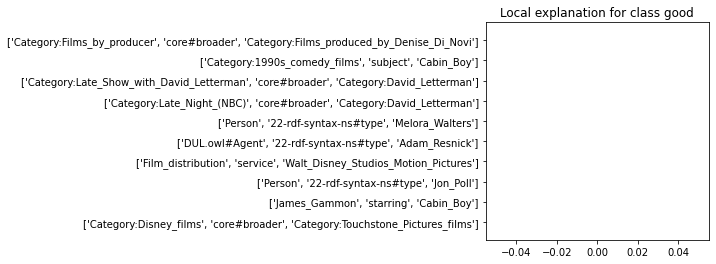

In [11]:
figsize = (4, .4*len(explanation.as_list()))
fig = explanation.as_pyplot_figure(figsize=figsize)

In [ ]:
explanation.as_list()

<AxesSubplot:>

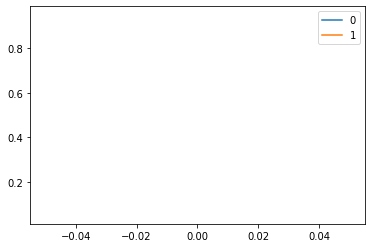

In [12]:
pd.DataFrame(labels).plot()

# thesis: show plot with/without single_run

In [13]:
wv_old = explainer.old_transformer.embedder._model.wv
wv_new = explainer.transformer.embedder._model.wv
def embedding(URI, new):
    wv = wv_new if new else wv_old
    return wv.get_vector(URI)

In [14]:
# Check if the movie embedding itself drifted
all(embedding(explained_entity_uri, new=True) == embedding(explained_entity_uri, new=False))

True

In [24]:
for walk in explainer.indexedWalks.walks(e):
    for step in walk:
        if not step in changed and not step == e:
            print(step)

In [160]:
drifted = 0
changed = []

for i in range(len(wv_old)):
    if not (wv_old[i] == wv_new[i]).all():
        changed.append(wv_new.index_to_key[i])

        drifted += 1

print(drifted) 

198


In [3]:
explainer.transformer.embedder._model.wv.most_similar(explainer.new_embeddings[0])

[('http://dbpedia.org/resource/Cabin_Boy', 0.8919827342033386),
 ('http://dbpedia.org/resource/Sorority_Boys', 0.4870971739292145),
 ('http://dbpedia.org/resource/Deuce_Bigalow:_Male_Gigolo',
  0.4668467938899994),
 ('http://dbpedia.org/resource/Confessions_of_a_Shopaholic_(film)',
  0.4478405714035034),
 ('http://dbpedia.org/resource/Bringing_Down_the_House_(film)',
  0.44290289282798767),
 ('http://dbpedia.org/resource/Just_Visiting_(film)', 0.42650309205055237),
 ('http://dbpedia.org/resource/The_Hot_Chick', 0.41822385787963867),
 ('http://dbpedia.org/resource/Category:Disney_films', 0.4161430597305298),
 ('http://dbpedia.org/resource/Two_Girls_and_a_Guy', 0.410209059715271),
 ('http://dbpedia.org/resource/Category:American_military_personnel_of_the_Vietnam_War',
  0.4044659435749054)]

In [4]:
import numpy as np



In [5]:
with open("corpus.text", "wb") as f:
    pickle.dump(corpus, f)
    

Error: Canceled future for execute_request message before replies were done

### Experiments

In [ ]:
unique_triples = len(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri)))
unique_triples

In [162]:
keanu = embedding("http://dbpedia.org/resource/Keanu_Reeves", new=True)
matrix = embedding("http://dbpedia.org/resource/The_Matrix", new=True)
wv_new.most_similar(matrix-keanu, topn=len(wv_new))[0]
wv_new.most_similar(positive=["http://dbpedia.org/resource/The_Matrix"], negative=["http://dbpedia.org/resource/Keanu_Reeves"])

[('http://dbpedia.org/resource/The_Matrix_Reloaded', 0.6344772577285767),
 ('http://dbpedia.org/resource/Blade_Runner', 0.5671509504318237),
 ('http://dbpedia.org/resource/Inception', 0.5541456341743469),
 ('http://dbpedia.org/resource/Category:Films_that_won_the_Best_Sound_Mixing_Academy_Award',
  0.5283929705619812),
 ('Martial arts science fiction films', 0.5204886794090271),
 ('http://dbpedia.org/resource/Category:Martial_arts_science_fiction_films',
  0.5202658176422119),
 ('http://dbpedia.org/resource/Iron_Man_3', 0.5084689855575562),
 ('http://dbpedia.org/resource/The_Empire_Strikes_Back', 0.5070682168006897),
 ('http://dbpedia.org/resource/Category:Science_fiction_action_films',
  0.4893838167190552),
 ('http://dbpedia.org/resource/Category:Films_that_won_the_Best_Visual_Effects_Academy_Award',
  0.48421862721443176)]

In [26]:
movie_search = lambda query: [(i,x) for i,x in enumerate(movies) if query.lower() in x.lower()]
movie_search("batman")

[(1723, 'http://dbpedia.org/resource/Batman_&_Robin_(film)')]